In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torchvision
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import time
from PIL import Image, ImageDraw
from skimage import io, transform
from sklearn import preprocessing
from torchvision.transforms import ToTensor
import torch
import cv2
from skimage.feature import hog
from skimage import data, exposure, img_as_float, filters
import torch.nn.functional as F
import transforms
#еще один способ нахождения косинусного сходства
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances


ModuleNotFoundError: No module named 'transforms'

In [71]:
flags = pd.read_csv('C:/Users/ligra/Desktop/диплом/fashion-dataset/styles.csv', error_bad_lines=False)

C:\Users\ligra\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11

In [72]:
flags = flags.rename(columns={'masterCategory':'gen_category',
                      'subCategory':'sub_category',
                      'articleType':'type',
                      'baseColour':'color',
                      'productDisplayName':'product_name'})
flags

,id,gender,gen_category,sub_category,type,color,season,year,usage,product_name
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [73]:
#создание массива уникальных меток
unique_tags = []
columns_name = flags.columns
for i in range(1, len(columns_name)):
    for tag in flags[columns_name[i]].unique():
        tag = str(tag).replace(' ', '_')
        unique_tags.append(tag)

In [74]:
#преобразование и кодирование меток
le = preprocessing.LabelEncoder()
le.fit(unique_tags)
list(le.classes_) #изменяет метки некорректно, нужен вывод этой строки!
le.transform(flags['gender'])

array([16897, 16897, 30486, ..., 16897, 30486, 30486])

In [75]:
# пути к изображениям
img_path = 'C:/Users/ligra/Desktop/диплом/fashion-dataset/images'
images_path = []
for id in flags.id:
      images_path.append(img_path+'/'+str(id)+'.jpg') 
images_path[1]

'C:/Users/ligra/Desktop/диплом/fashion-dataset/images/39386.jpg'

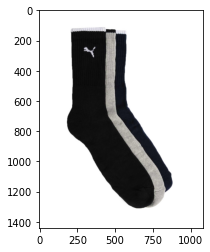

In [76]:
images = []
for path in range(1,20):
    image = Image.open(images_path[path]) 
    pix = image.load() #попиксельная загрузка
    images.append(image)
    
plt.imshow(images[7]) #вывод изображения

In [77]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize((224, 224)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

In [78]:
class СlothesDataset(Dataset):

    def __init__(self, csv_file, img_path, transform=None):
        self.flags = pd.read_csv(csv_file, error_bad_lines=False)
        self.path = img_path
        self.transform = transform
        
        #создание массива уникальных меток
        unique_tags = []
        columns_name = flags.columns
        for i in range(1, len(columns_name)):
            for tag in flags[columns_name[i]].unique():
                tag = str(tag).replace(' ', '_')
                unique_tags.append(tag)
        

    def __len__(self):
        return len(self.flags)

    def __getitem__(self, idx):
        img_name = os.path.join(self.path, str(self.flags.iloc[idx, 0])+'.jpg')
        image = io.imread(img_name)
        tags = self.flags.iloc[idx, 1:].values
        
        for i in range(len(tags)):
            tags[i] = str(tags[i]).replace(' ', '_')
            tags[i] = unique_tags.index(tags[i])
            
        tags = tags.astype('float').reshape(-1, 9)
        sample = {'image': image, 'tags': tags}

        if self.transform:
            sample = self.transform(sample)

        return sample
    

In [79]:
#Преобразование ndarrays экземпляра в Tensors
class ToTensor(object):

    def __call__(self, sample):
        image, tags = sample['image'], sample['tags']

        # numpy изображение: H x W x C
        # torch изображение: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'tags': torch.from_numpy(tags)}

In [106]:
#Масштабирование изображения в заданный размер, чтобы все изображения были одного размера и можно было
#применять косинусное сходство
class Rescale(object):
     #output_size (tuple or int): Требуемый размер вывода. 
     #Если tuple, вывод соответствует output_size. 
     #Если int, меньшие края изображения соответствуют 
     #output_size сохраняя прежнее соотношение сторон.

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, tags = sample['image'], sample['tags']
        image = np.array(image)

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = \
                       self.output_size * h / w, self.output_size
            else:
                new_h, new_w = \
                       self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h и w меняются местами для ориентиров 
        # x и y оси - это оси 1 и 0 соответственно
        #tags = tags * [new_w / w, new_h / h]

        return {'image': img, 'tags': tags}

In [112]:
#итерация по набору данных, проверка корректности работы
clothes_dataset = СlothesDataset(csv_file='C:/Users/ligra/Desktop/диплом/fashion-dataset/styles.csv',
                                img_path='C:/Users/ligra/Desktop/диплом/fashion-dataset/images',
                                transform=torchvision.transforms.Compose([
                                Rescale(1200),
                                ToTensor()]))
for i in range(0, 3):
    img = clothes_dataset[i]['image']
    print(i, sample['image'].shape, sample['tags'].shape)
    
plt.imshow(clothes_dataset[10])

C:\Users\ligra\AppData\Local\Temp/ipykernel_14668/479040901.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  clothes_dataset = СlothesDataset(csv_file='C:/Users/ligra/Desktop/диплом/fashion-dataset/styles.csv',
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields,

TypeError: pic should be PIL Image or ndarray. Got <class 'dict'>

In [82]:
#итерация по набору данных, проверка корректности работы
clothes_dataset = СlothesDataset(csv_file='C:/Users/ligra/Desktop/диплом/fashion-dataset/styles.csv',
                                img_path='C:/Users/ligra/Desktop/диплом/fashion-dataset/images')
for i in range(0, 10):
    sample = clothes_dataset[i]

    print(i, sample['image'].shape, sample['tags'].shape)

C:\Users\ligra\AppData\Local\Temp/ipykernel_14668/2911532429.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  clothes_dataset = СlothesDataset(csv_file='C:/Users/ligra/Desktop/диплом/fashion-dataset/styles.csv',
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields

0 (2400, 1800, 3) (1, 9)
1 (2400, 1800, 3) (1, 9)
2 (1440, 1080, 3) (1, 9)
3 (2400, 1800, 3) (1, 9)
4 (1440, 1080, 3) (1, 9)
5 (2400, 1800, 3) (1, 9)
6 (2400, 1800, 3) (1, 9)
7 (1440, 1080, 3) (1, 9)
8 (1440, 1080, 3) (1, 9)
9 (1440, 1080, 3) (1, 9)


In [83]:
#расчет hog
#hog = cv2.HOGDescriptor()
#h = hog.compute(np.array(images[7]))

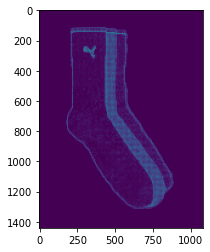

In [84]:
#Получение HOG тестового изображения
fd, hog_image = hog(np.array(images[7]), orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 
plt.imshow(hog_image_rescaled)

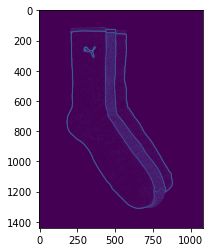

In [85]:
#Получение границ тестового изображения с помощью фильтра Собеля
gray_img = cv2.cvtColor(np.array(images[7]), cv2.COLOR_BGR2GRAY)
sobel_img = filters.sobel(gray_img)
plt.imshow(sobel_img)

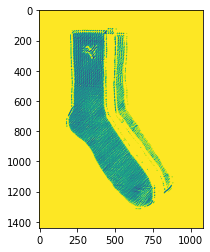

In [86]:
#Получение текстуры изображения
g_kernel = cv2.getGaborKernel((21, 21), 8.0, np.pi/4, 10.0, 0.5, 0, ktype=cv2.CV_32F)
texture_img = cv2.filter2D(gray_img, cv2.CV_8UC3, g_kernel)
plt.imshow(texture_img)

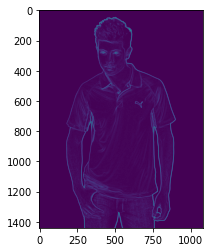

In [87]:
#нахождение косинусного сходства для двух тестовых изображений
#нужно, чтобы все изображения были одинаковых размеров
gray_img1 = cv2.cvtColor(np.array(images[3]), cv2.COLOR_BGR2GRAY)
sobel_img1 = filters.sobel(gray_img1)
gray_img2 = cv2.cvtColor(np.array(images[7]), cv2.COLOR_BGR2GRAY)
sobel_img2 = filters.sobel(gray_img2)
plt.imshow(sobel_img1)

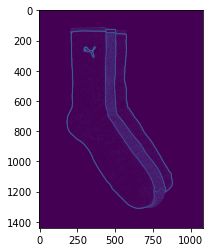

In [88]:
plt.imshow(sobel_img2)

In [89]:
#нерабочий вариант
img1 = torch.FloatTensor(sobel_img1)
img2 = torch.FloatTensor(sobel_img2)
result = F.cosine_similarity(img1, img2, dim=0)
print(result)

tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [90]:
#вычисление косинусного сходства
result=cosine_similarity(gray_img1.reshape(1,-1),gray_img2.reshape(1,-1))
result

array([[0.87043472]])